<h2>Algae classifier for the coasts of central Chile, Southamerica</h2>
<p>Prepared by Félix Garcias, f.garcias@uc.cl</p>


## Introductión
This projects includes both back-end (Keras, Flask with dependencies) and the implementation (HTML, CSS, JS) that was finally hosted on Heroku.

This app is designed for those people who they like to walk through the intertidal rocky and the coast in general. Therefore, this model was trained with images of stranded algae on the beach and others algae that we find naturally on rocks. For images taken in laboratory circumstances or other situation, the model could present greater percentage of error to classify.

For this first version, approximately 3.890 images were used, which were separated into a training, test and validation sample (3.311, 585 and 67, respectively).

The images were captured in the following geographic zone:


In [ ]:
import folium
m = folium.Map(
    location=[-33.41, -71.65],
    zoom_start=8,
    tiles='Stamen Terrain'
)

tooltip = 'App Algae Classifier'

folium.Marker([-33.41, -71.70], popup='App Algae Classifier', tooltip=tooltip).add_to(m)


m

For this version, transfer learning was used.

Transfer Learning is a machine learning method in which a model with a very complex structure is reused to build a new model.
In this context, I used MobileNetV2 which contains 32 filters in the initial convolutional layer, followed by 19 residual bottleneck layers.


<h3>Construct the Convolutional Neuronal Network (CNN) Architecture and train the model with data</h3>

#### import packages and libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import os, stat, time
from os.path import dirname as up
import h5py 
import cv2
import pickle
import PIL
from PIL import Image


In [2]:
import tensorflow as tf
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import optimizers
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dropout, Flatten, Dense, Activation
from tensorflow.python.keras.layers import  Convolution2D, MaxPooling2D
from tensorflow.python.keras import backend as K
from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Activation
from tensorflow.python.keras.layers.core import Dense, Flatten, Dropout
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.metrics import categorical_crossentropy
from tensorflow.python.keras.regularizers import l2
from tensorflow.python.keras.layers.convolutional import *
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.optimizers import SGD
from tensorflow.keras.models import model_from_json
from tensorflow.python.framework import ops
ops.reset_default_graph()

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

### Transforming the images a picke file

The pickle module can store things such as data types such as booleans, strings, and byte arrays, lists, dictionaries, functions, and more. Note: The concept of pickling is also known as serialization, marshaling, and flattening. However, the point is always the same to save an object to a file for later retrieval.

In [ ]:

#data_dir = "./data/Algas2"


#categories = ['Sp1 Nothogenia fastigiata', 'Sp2 Ahnfeltiopsis durvillei', 'Sp3 Centroceras clavulatum', 'Sp4 Mazzaella laminarioides', 'Sp5 Porphyra columbina', 'Sp6 Chondracanthus chamissoi', 'Sp7 Ulva lactuca', 'Sp8 Lessonia Sp', 'Sp9 Macrocystis pyrifera', 'Sp10 Durvillaea antarctica', 'Sp11 Ulva intestinalis','other']


#data = []

#def make_data():
#    for category in categories:
#        path = os.path.join(data_dir, category) # ./data/flowers/dasiy

#        for img_name in os.listdir(path):
#            image_path = os.path.join(path, img_name)
#            label = categories.index(category)
#            image = cv2.imread(image_path)

#            try:
#                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#                image = cv2.resize(image, (224,224),3)

#                image =np.array(image, dtype=np.float32)

#                data.append([image, label])

#            except Exception as e:
#                pass

#    print(len(data))

#    pik = open('data.pickle', 'wb')
#    pickle.dump(data, pik)
#    pik.close()



#make_data()

#def load_data():
#    pick = open('data.pickle', 'rb')
#    data = pickle.load(pick)
#    pick.close()

#    np.random.shuffle(data)

#    feature = []
#    labels = []

#    for img, label in data:
#        feature.append(img)
#        labels.append(label)

#    feature = np.array(feature, dtype=np.float32)
#    labels = np.array(labels)

#    feature = feature/255.0

#    return [feature, labels]

In [3]:
def load_data():
    pick = open('data.pickle', 'rb')
    data = pickle.load(pick)
    pick.close()

    np.random.shuffle(data)

    feature = []
    labels = []

    for img, label in data:
        feature.append(img)
        labels.append(label)

    feature = np.array(feature, dtype=np.float32)
    labels = np.array(labels)

    feature = feature/255.0

    return [feature, labels]

In [4]:
from tensorflow.python.keras import applications

### Train and test sample

Using sklearn.model_selection to separate the images into a training sample and a test sample. The test sample contains 15% of the data.

In [5]:
from sklearn.model_selection import train_test_split

(feature, labels) = load_data()

x_train, x_test, y_train, y_test = train_test_split(feature, labels, test_size=0.15)

In [6]:
print("There are {} training examples".format(x_train.shape[0]))
print("There are {} test examples".format(x_test.shape[0]))
print("There are {} training examples".format(y_train.shape[0]))
print("There are {} test examples".format(y_test.shape[0]))

There are 3311 training examples
There are 585 test examples
There are 3311 training examples
There are 585 test examples


### Seeing some images of the training sample

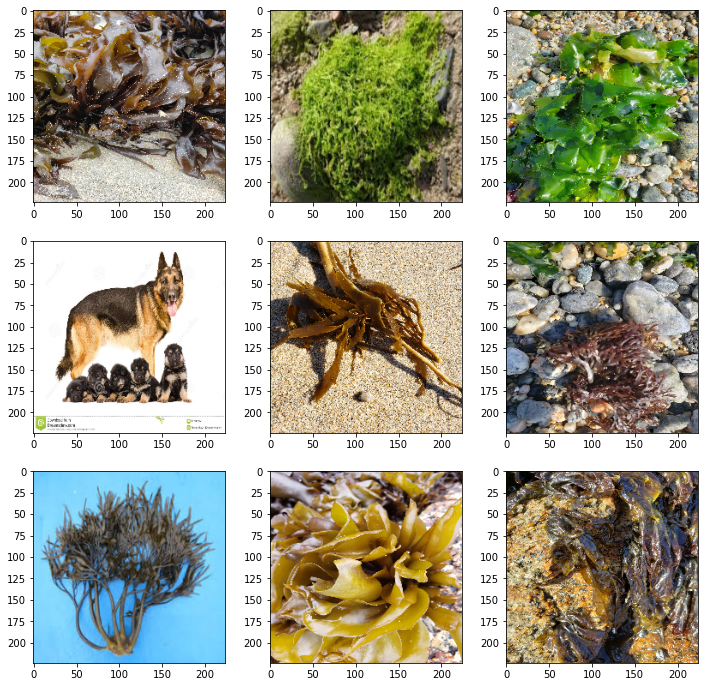

In [7]:
plt.figure(figsize=(12,12))
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(x_train[i+330])
# show the figure
plt.show()

### ImagenDataGenerator

In general, when we have a relatively small number of images, we can increase the number by modifying the original images (zooming, scaling, horizontal flip, etc). With this, we can partially improve the quality of the model.

In [ ]:
augmenter = ImageDataGenerator(horizontal_flip=True,
                               rotation_range=0.15,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               zoom_range=0.15,
                               shear_range=0.1,
                               fill_mode='nearest')

### Building the non-sequential Convolutional Neural Network (CNN)

Although sequential convolutional models were tested in which each layer is a linear relationship in sequence, and the structure of the model is formulated through a list, in this first proposal a general model was chosen, with which a structure can be built network more flexibly and establish the relationship of each level.

Since an ImagenDataGenerator process was used, which generally exerts a negative autocorrelation effect on the model, I opted to use a dropout process (25%)

In [ ]:

input_layer = tf.keras.layers.Input([224,224,3])

conv1 = tf.keras.layers.Conv2D(filters =32, kernel_size=(5,5), padding='Same',
    activation = 'relu')(input_layer)

pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv1)


conv2 = tf.keras.layers.Conv2D(filters =64, kernel_size=(3,3), padding='Same',
    activation = 'relu')(pool1)

pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2))(conv2)


conv3 = tf.keras.layers.Conv2D(filters =96, kernel_size=(3,3), padding='Same',
    activation = 'relu')(pool2)

pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv3)


conv4 = tf.keras.layers.Conv2D(filters =96, kernel_size=(3,3), padding='Same',
    activation = 'relu')(pool3)

pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv4)


flt1 = tf.keras.layers.Flatten()(pool4)

#flt2 = tf.layers.Dropout(flt1, rate=dropout)

dn1 = tf.keras.layers.Dense(512, activation='relu')(flt1)

drop = tf.keras.layers.Dropout(0.25, noise_shape=None, seed=None)(dn1)

out = tf.keras.layers.Dense(12, activation='softmax')(drop)

#out = tf.keras.layers.Dense(11, activation='softmax')(dn1)

model = tf.keras.Model(input_layer, out)

In [8]:
from tensorflow.keras.layers import GlobalAveragePooling2D

In [9]:
input_shape = (224, 224, 3) 
num_classes = 13  

base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, alpha=1.0, include_top=False)
w = base_model.output
w = GlobalAveragePooling2D()(w)
w = Dense(128, activation="relu")(w)
output = Dense(num_classes, activation="softmax")(w)
model = tf.keras.Model(inputs=[base_model.input], outputs=[output])



### Summary of the model architecture

In [10]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

### Compiling the model

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adadelta(), loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

### Model fit in 60 epoch

In [12]:
history = model.fit(x_train,y_train,steps_per_epoch=None,epochs=80,validation_data=(x_test,y_test))


Epoch 1/80
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
104/104 [==============================] - ETA: 0s - loss: 2.6588 - accuracy: 0.0957WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000021A1D6FF0D8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`

### Defining a function to graph the fit of the model (accuracy) and its loss in each epoch

In [13]:
def plot_model_history(model_name, history, epochs):
  
  print(model_name)
  plt.figure(figsize=(15, 5))
  
  # summarize history for accuracy
  plt.subplot(1, 2 ,1)
  plt.plot(np.arange(0, len(model.history.history['accuracy'])), model.history.history['accuracy'], 'r')
  plt.plot(np.arange(1, len(model.history.history['val_accuracy'])+1), model.history.history['val_accuracy'], 'g')
  plt.xticks(np.arange(0, epochs+1, epochs/10))
  plt.title('Training Accuracy vs. Validation Accuracy')
  plt.xlabel('Num of Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'validation'], loc='best')
  
  plt.subplot(1, 2, 2)
  plt.plot(np.arange(1, len(model.history.history['loss'])+1), model.history.history['loss'], 'r')
  plt.plot(np.arange(1, len(model.history.history['val_loss'])+1), model.history.history['val_loss'], 'g')
  plt.xticks(np.arange(0, epochs+1, epochs/10))
  plt.title('Training Loss vs. Validation Loss')
  plt.xlabel('Num of Epochs')
  plt.ylabel('Loss')
  plt.legend(['train', 'validation'], loc='best')
  
  
  plt.show()

### Accuracy and Lost
When making the graph, a good fit of the model is observed, which reached an accuracy of 96% in the training sample and 93% in the test sample.

model_scratch


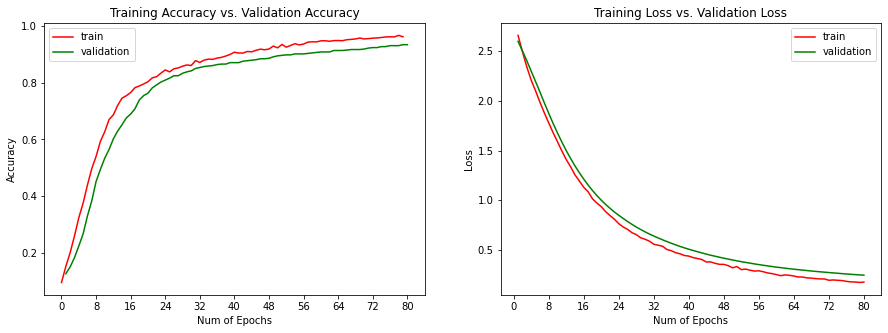

In [14]:
plot_model_history('model_scratch', history.history, 80)

### Generating the confusion matrix

In [15]:
x_traincm,x_val,y_traincm,y_val = train_test_split(x_train,y_train,test_size = 0.15)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


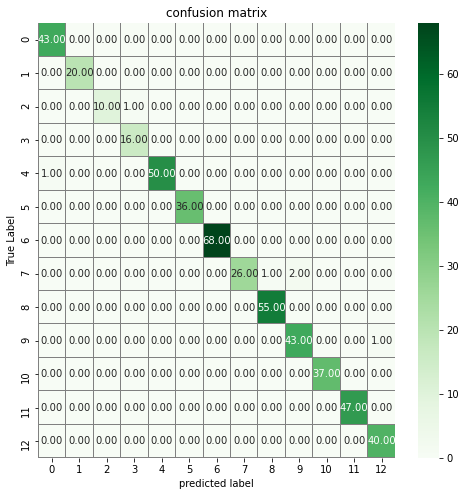

In [16]:
import seaborn as sb
from sklearn.metrics import confusion_matrix
Y_pred = model.predict(x_val)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = y_val
confusion_mtx = confusion_matrix(Y_true,Y_pred_classes)
f,ax = plt.subplots(figsize = (8,8))
sb.heatmap(confusion_mtx,annot=True,linewidths = 0.01,cmap="Greens",
            linecolor = "gray",fmt = ".2f",ax=ax
            )
plt.xlabel("predicted label")
plt.ylabel("True Label")
plt.title("confusion matrix")
plt.show()

### Formatting the confusion matrix

In [17]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
       # cm[np.isnan(cm)] = 0.0

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

### Confusion matrix

Although the confusion matrix shows a 96% fit, the training sample in each epoch showed a maximum of 93%. In this context, the model still confuses *Plocamium cartilagineum* with *Centroceras clavulatum*. On the other hand, when the model is test with a validation sample (images that were not considered at any stage of the modeling) the brown macro algae also showed a relatively high degree of confusion.

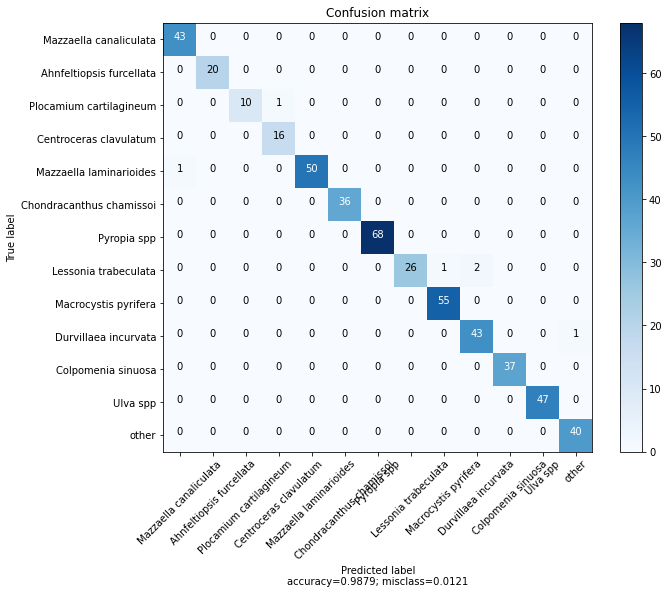

In [32]:
#categories = ['Nothogenia fastigiata', 'Ahnfeltiopsis durvillei', 'Centroceras clavulatum', 'Mazzaella laminarioides', 'Porphyra columbina', 'Chondracanthus chamissoi', 'Ulva lactuca', 'Lessonia Sp', 'Macrocystis pyrifera', 'Durvillaea antarctica','Ulva intestinalis','other']
categories = ['Mazzaella canaliculata', 'Ahnfeltiopsis furcellata', 'Plocamium cartilagineum', 'Centroceras clavulatum', 'Mazzaella laminarioides', 'Chondracanthus chamissoi', 'Pyropia spp', 'Lessonia trabeculata', 'Macrocystis pyrifera', 'Durvillaea incurvata', 'Colpomenia sinuosa','Ulva spp','other']

plot_confusion_matrix(confusion_mtx,categories, cmap=None, normalize=False)

### Saving the weights and the model to implement in flask

In [19]:
# Save the Model Weights
model.save_weights('model_80_eopchs_adam_20210830_tr.h5')

In [20]:
# Save the Model to JSON
model_json = model.to_json()
with open('model_adam_20210830_tr.json', 'w') as json_file:
    json_file.write(model_json)
    
print('Model saved to the disk.')

Model saved to the disk.


In [21]:
# Get the architecture of CNN
json_file = open('model_adam_20210830_tr.json')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

In [22]:
# Get weights into the model
loaded_model.load_weights('model_80_eopchs_adam_20210830_tr.h5')

In [24]:
# Define optimizer and run
opt = keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
loaded_model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=opt)

### Testing the model with the validation sample

In [26]:
# test imagen
IMG = Image.open('C:/Users/felix/Desktop/Algas/ProyectoAlgas/deploy/project_alga/ValidationSamples/25.jpg')
print(type(IMG))
IMG = IMG.resize((224, 224))
IMG = np.array(IMG)
print('po array = {}'.format(IMG.shape))
IMG = np.true_divide(IMG, 255)
IMG = IMG.reshape(-1, 224, 224, 3)
print(type(IMG), IMG.shape)

predictions = loaded_model.predict(IMG)

print(loaded_model)
predictions_c = np.argmax(predictions, axis=1)
print(predictions, predictions_c)

<class 'PIL.JpegImagePlugin.JpegImageFile'>
po array = (224, 224, 3)
<class 'numpy.ndarray'> (1, 224, 224, 3)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[[4.4608978e-04 3.9906293e-04 7.9312718e-05 7.3704391e-04 7.2691677e-04
  5.9959624e-04 3.8582354e-04 9.0008427e-04 1.3620107e-03 3.2072124e-04
  7.5142557e-04 9.9158680e-01 1.7050961e-03]] [11]


### Images of the test sample with real label and predicted

Note that the model still confuses $Nothogenia$ $fastigiata$ with $Chondracanthus$ $chamissoi$

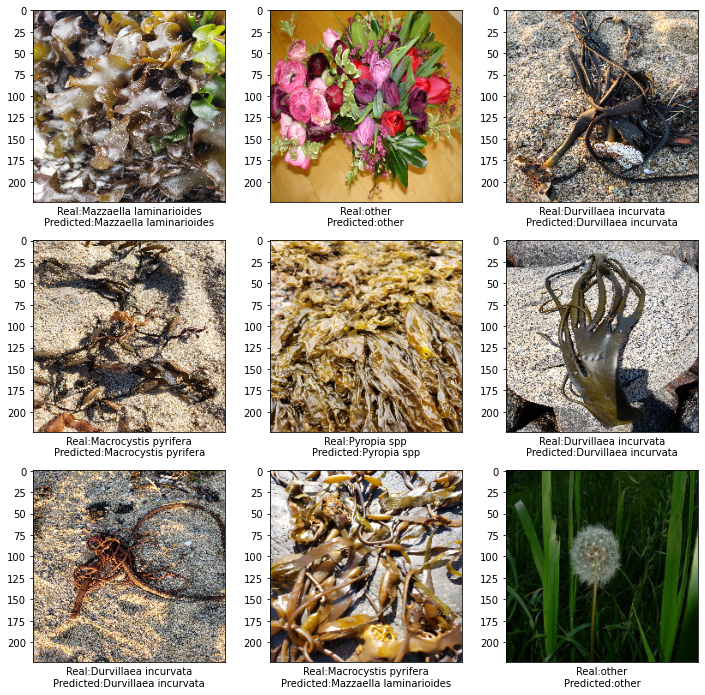

In [33]:
prediction2 = model.predict(x_test)

plt.figure(figsize=(12,12))

for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_test[i+2])
    plt.xlabel('Real:'+ categories[y_test[i+2]]+'\n'+'Predicted:'+
              categories[np.argmax(prediction2[i+2])])
    
    plt.xticks([])
    
plt.show()

More images of the test sample with real label and predicted

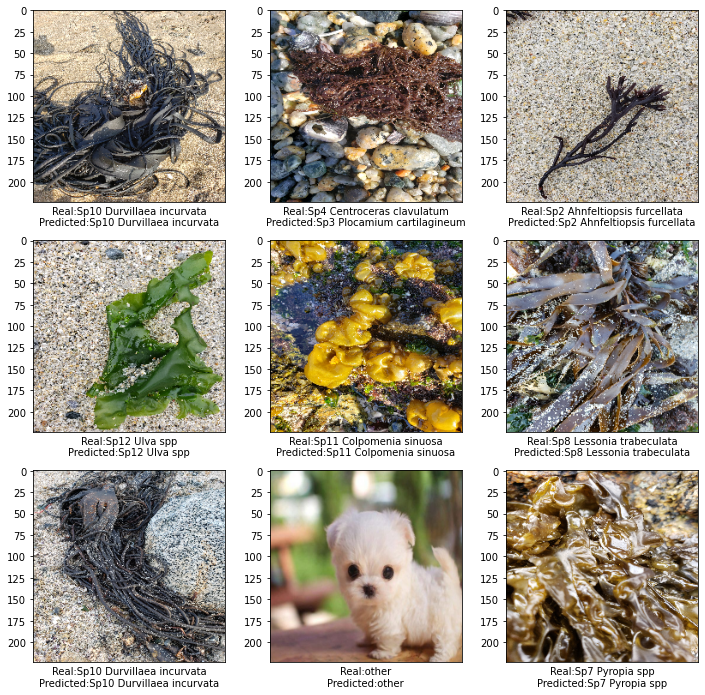

In [31]:

plt.figure(figsize=(12,12))

for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_test[i+18])
    plt.xlabel('Real:'+ categories[y_test[i+18]]+'\n'+'Predicted:'+
              categories[np.argmax(prediction2[i+18])])
    
    plt.xticks([])
    
plt.show()